In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector

from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np

Include problem statement here

First we write a function that encodes an input boolean, $x_0$, into the corresponding 5-qubit logic state $\ket{0_L}$ or $\ket{1_L}$

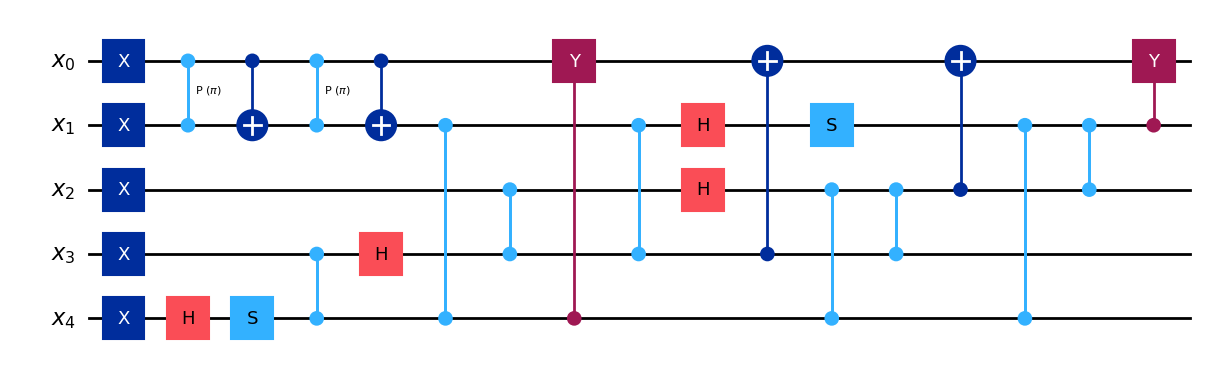

In [351]:
def encode(x0,qc,qr):
    if x0==1:
        qc.x(qr)
    # controlled phase flip - if the input state is |1>,
    # then flip the global phase by pi
    qc.cp(np.pi,qr[0],qr[1])
    qc.cx(qr[0],qr[1])
    qc.cp(np.pi,qr[0],qr[1])
    qc.cx(qr[0],qr[1])
    
    qc.h(qr[4])
    qc.s(qr[4])
    # g1
    qc.cz(qr[4],qr[3])
    qc.cz(qr[4],qr[1])
    qc.cy(qr[4],qr[0])
    
    qc.h(qr[3])
    #g2
    qc.cz(qr[3],qr[2])
    qc.cz(qr[3],qr[1])
    qc.cx(qr[3],qr[0])

    qc.h(qr[2])
    #g3
    qc.cz(qr[2],qr[4])
    qc.cz(qr[2],qr[3])
    qc.cx(qr[2],qr[0])

    qc.h(qr[1])
    qc.s(qr[1])
    #g4
    qc.cz(qr[1],qr[4])
    qc.cz(qr[1],qr[2])
    qc.cy(qr[1],qr[0])

def encodeGate(x0):
    qr_physical = QuantumRegister(5, name='x')
    qc= QuantumCircuit(qr_physical)
    encode(x0, qc, qr_physical)
    return qc.to_gate(label='5-qubit \nencode')


qr_physical = QuantumRegister(5, name='x')
qc= QuantumCircuit(qr_physical)
encode(1, qc, qr_physical)
qc.draw(output='mpl')


We now start building the rest of the circuit. We first add the four neccessary syndromes

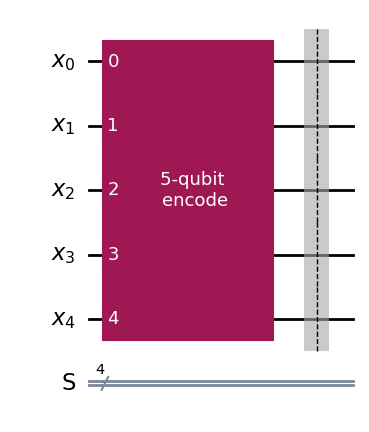

In [338]:
qr_physical = QuantumRegister(5, name='x')
qc= QuantumCircuit(qr_physical)
qc.compose(encodeGate(1),qr_physical, inplace=True)
qc.barrier()

syndrome = ClassicalRegister(4, name='S')
qc.add_register(syndrome)

#qc.y(qr_physical[4])

qc.draw(output='mpl')

Here, we will add in the random Pauli noise. Don't know how to do this yet

Now we apply the stablizers using classical measurements on four ancillas

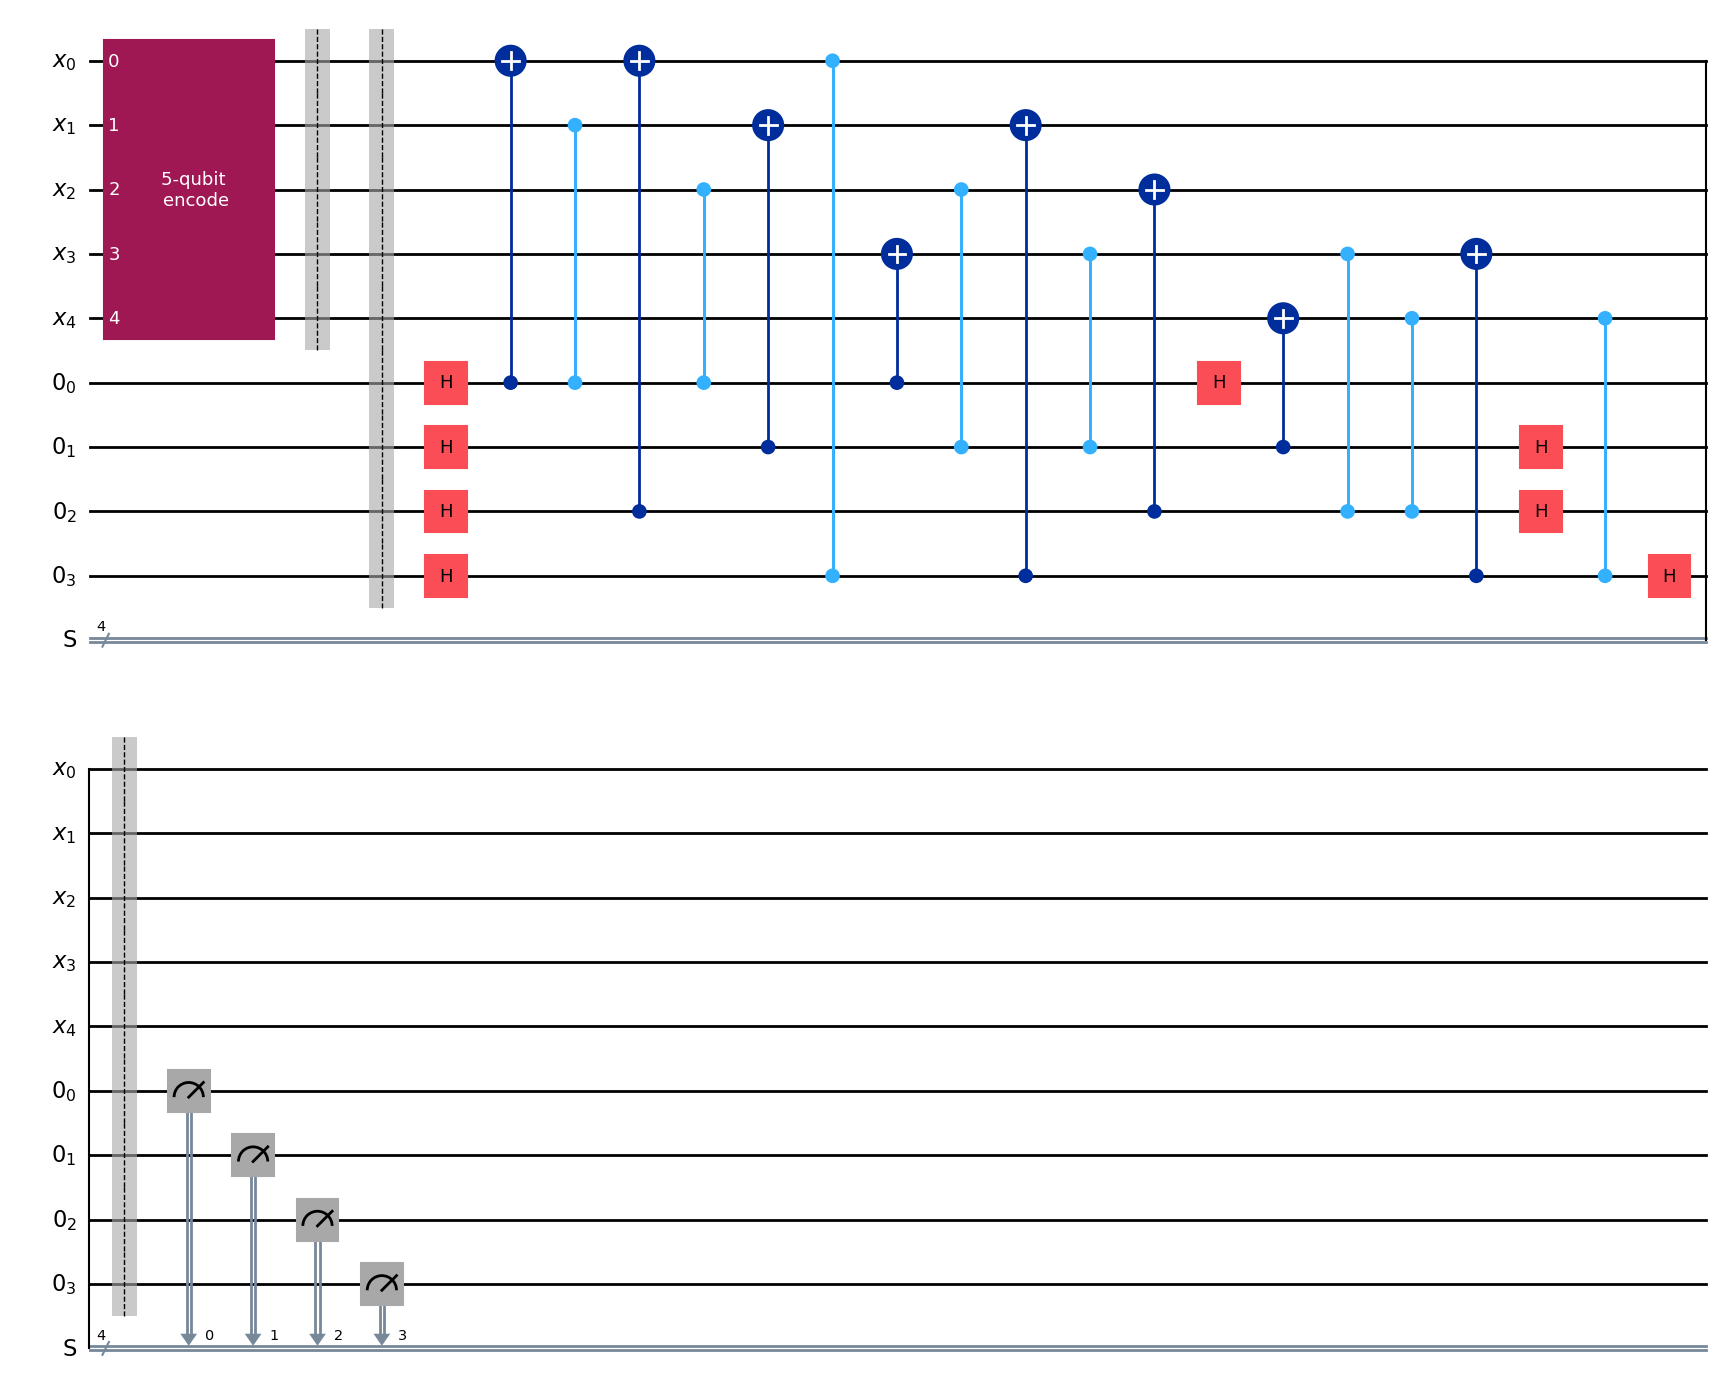

In [339]:
stabilizers = [
    'XZZXI',
    'IXZZX',
    'XIXZZ',
    'ZXIXZ'
]
def apply_stabilizers(qc, qr_physical,syndrome):
    anc = AncillaRegister(4, name='0')
    qc.add_register(anc)
    qc.barrier()
    qc.h(anc)
    for i, stab in enumerate(stabilizers):
        for j, bit in enumerate(stab):
            if bit == 'X':
                qc.cx(anc[i], qr_physical[j])
            elif bit == 'Z':
                qc.cz(anc[i], qr_physical[j])
    qc.h(anc)
    qc.barrier()
    for i in range(4):
        qc.measure(anc[i], syndrome[i])


apply_stabilizers(qc, qr_physical, syndrome)
qc.draw(output='mpl')

We now create a lookup table that dictates which gate to add based on which syndromes are activated

Pankaj I think there might be an issue here as sometimes the 0L state flips to the 1L state. It might be due to the reverse ordering of qiskit's list of syndromes vs the lookup table I used

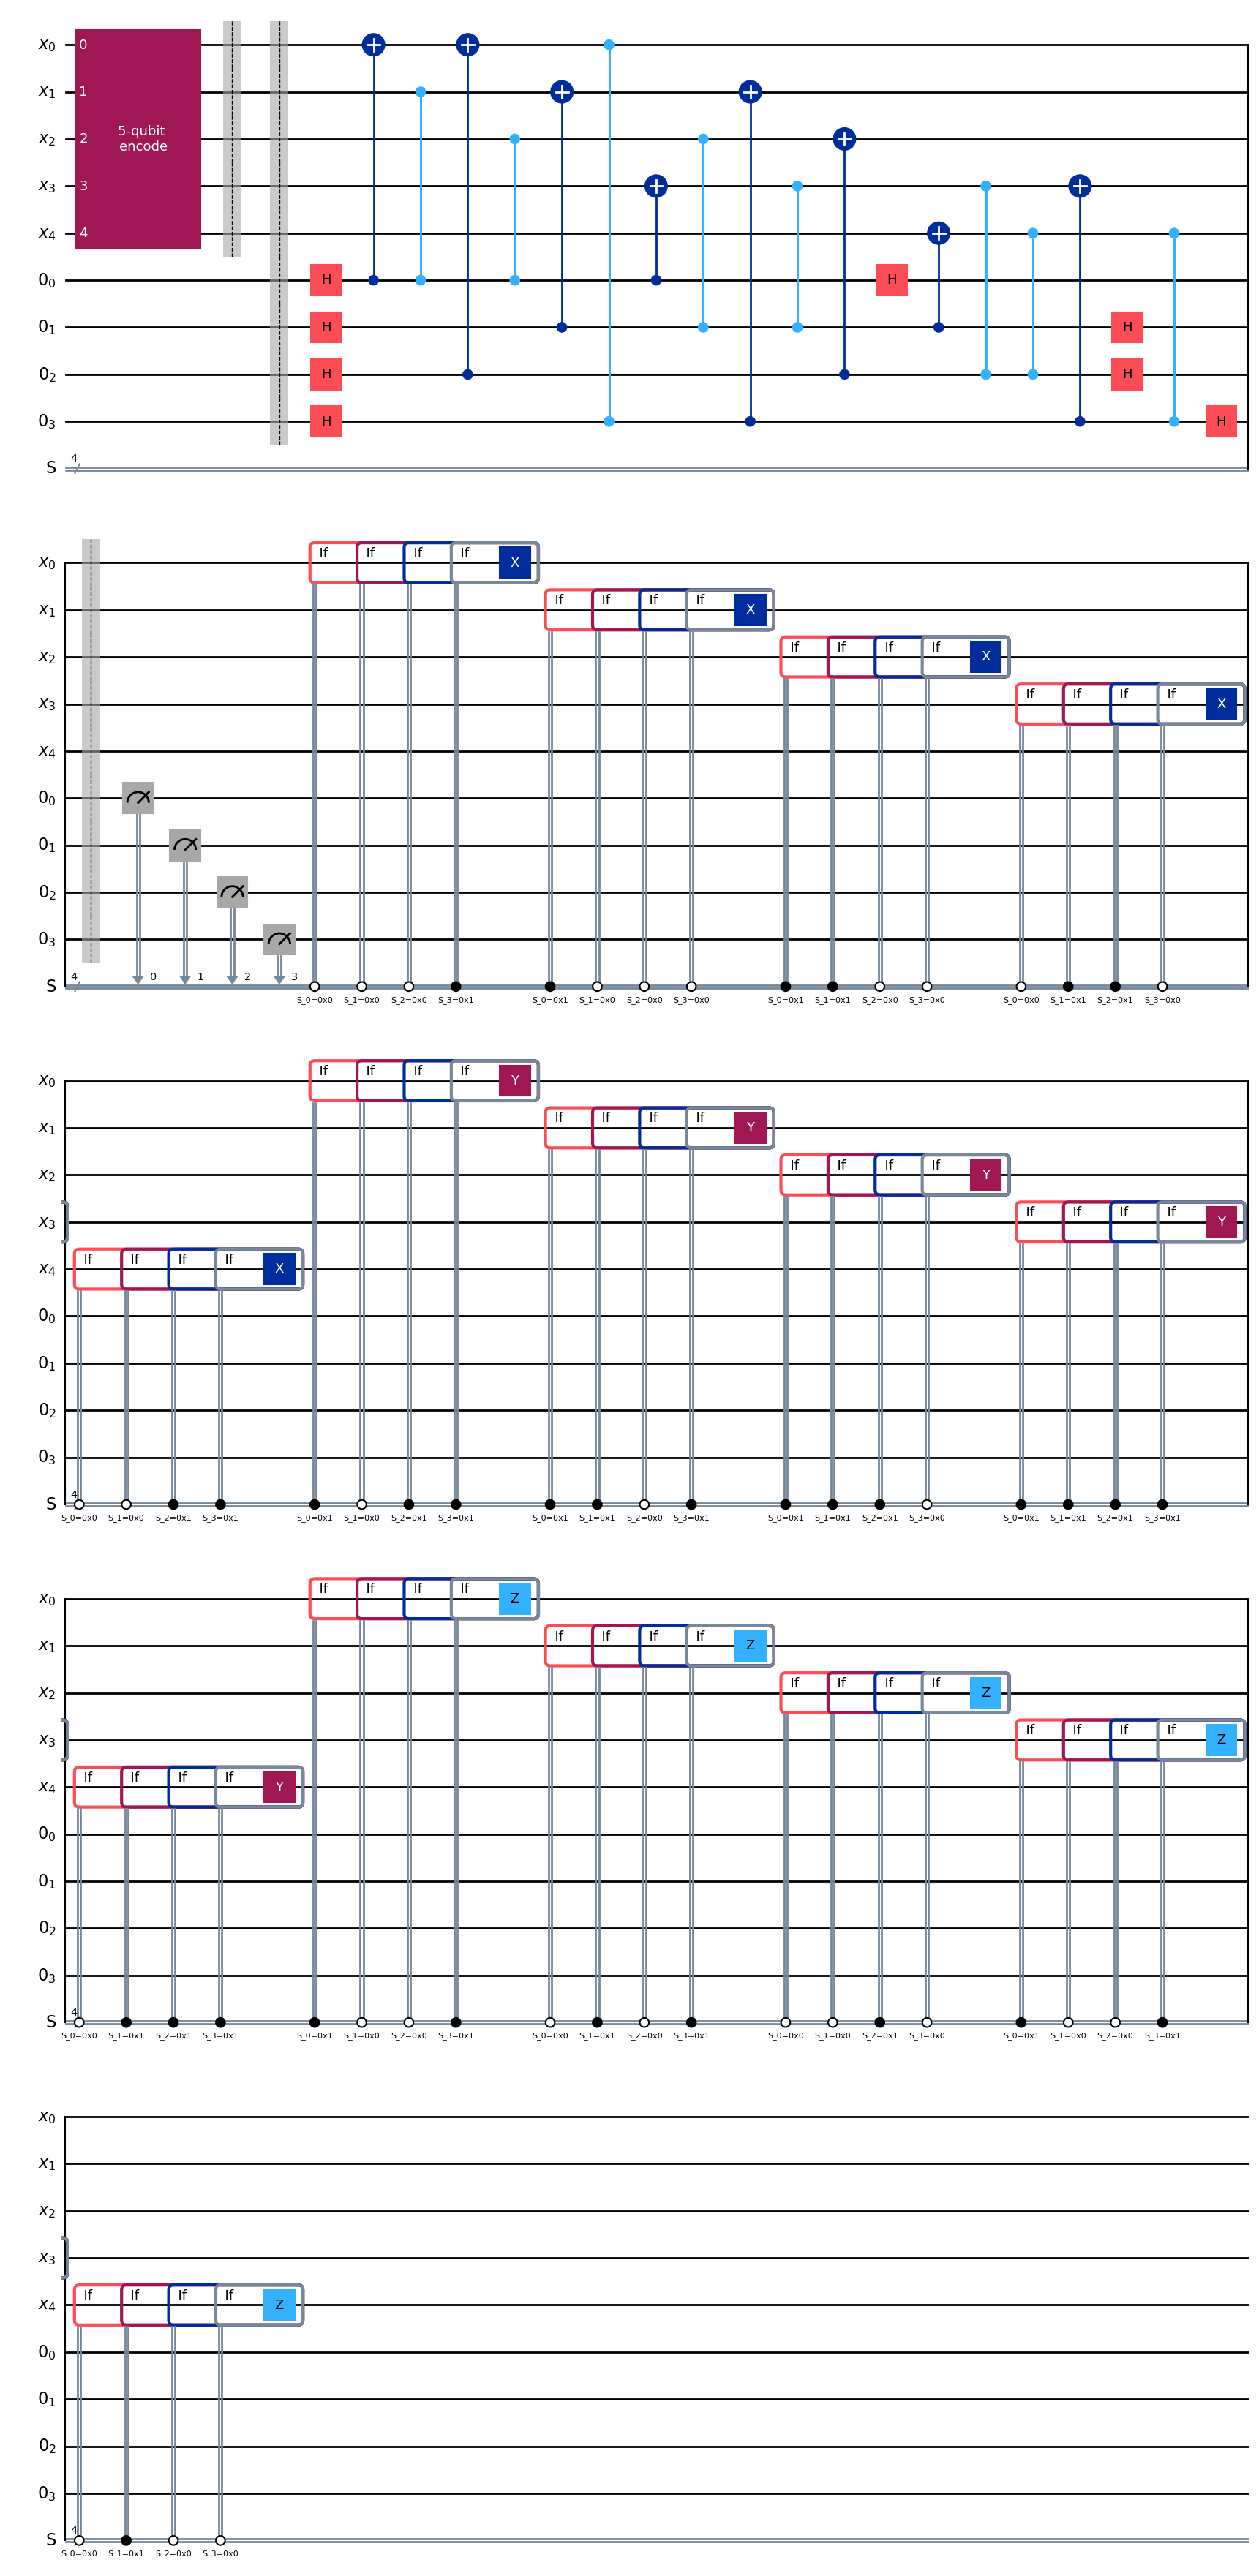

In [340]:
Lookup_Table = {
    'x1': [[0,0,0,1],'x',0],
    'x2': [[1,0,0,0],'x',1],
    'x3': [[1,1,0,0],'x',2],
    'x4': [[0,1,1,0],'x',3],
    'x5': [[0,0,1,1],'x',4],
    'y1': [[1,0,1,1],'y',0],
    'y2': [[1,1,0,1],'y',1],
    'y3': [[1,1,1,0],'y',2],
    'y4': [[1,1,1,1],'y',3],
    'y5': [[0,1,1,1],'y',4],
    'z1': [[1,0,0,1],'z',0],
    'z2': [[0,1,0,1],'z',1],
    'z3': [[0,0,1,0],'z',2],
    'z4': [[1,0,0,1],'z',3],
    'z5': [[0,1,0,0],'z',4],
    }
def CorrectErrors(qc, qr_physical, syndrome):
    for key in Lookup_Table:
        with qc.if_test((syndrome[0], Lookup_Table[key][0][0])):
            with qc.if_test((syndrome[1], Lookup_Table[key][0][1])):
                with qc.if_test((syndrome[2], Lookup_Table[key][0][2])):
                    with qc.if_test((syndrome[3], Lookup_Table[key][0][3])):
                        if Lookup_Table[key][1] == 'x':
                            qc.x(qr_physical[Lookup_Table[key][2]])
                        elif Lookup_Table[key][1] == 'y':
                            qc.y(qr_physical[Lookup_Table[key][2]])
                        elif Lookup_Table[key][1] == 'z':
                            qc.z(qr_physical[Lookup_Table[key][2]])
CorrectErrors(qc, qr_physical, syndrome)                            
qc.draw(output='mpl')


Finally, we construct the $\bar{Z}$ operator and measure the state of the system to be either $\ket{0_L}$ or $\ket{1_L}$

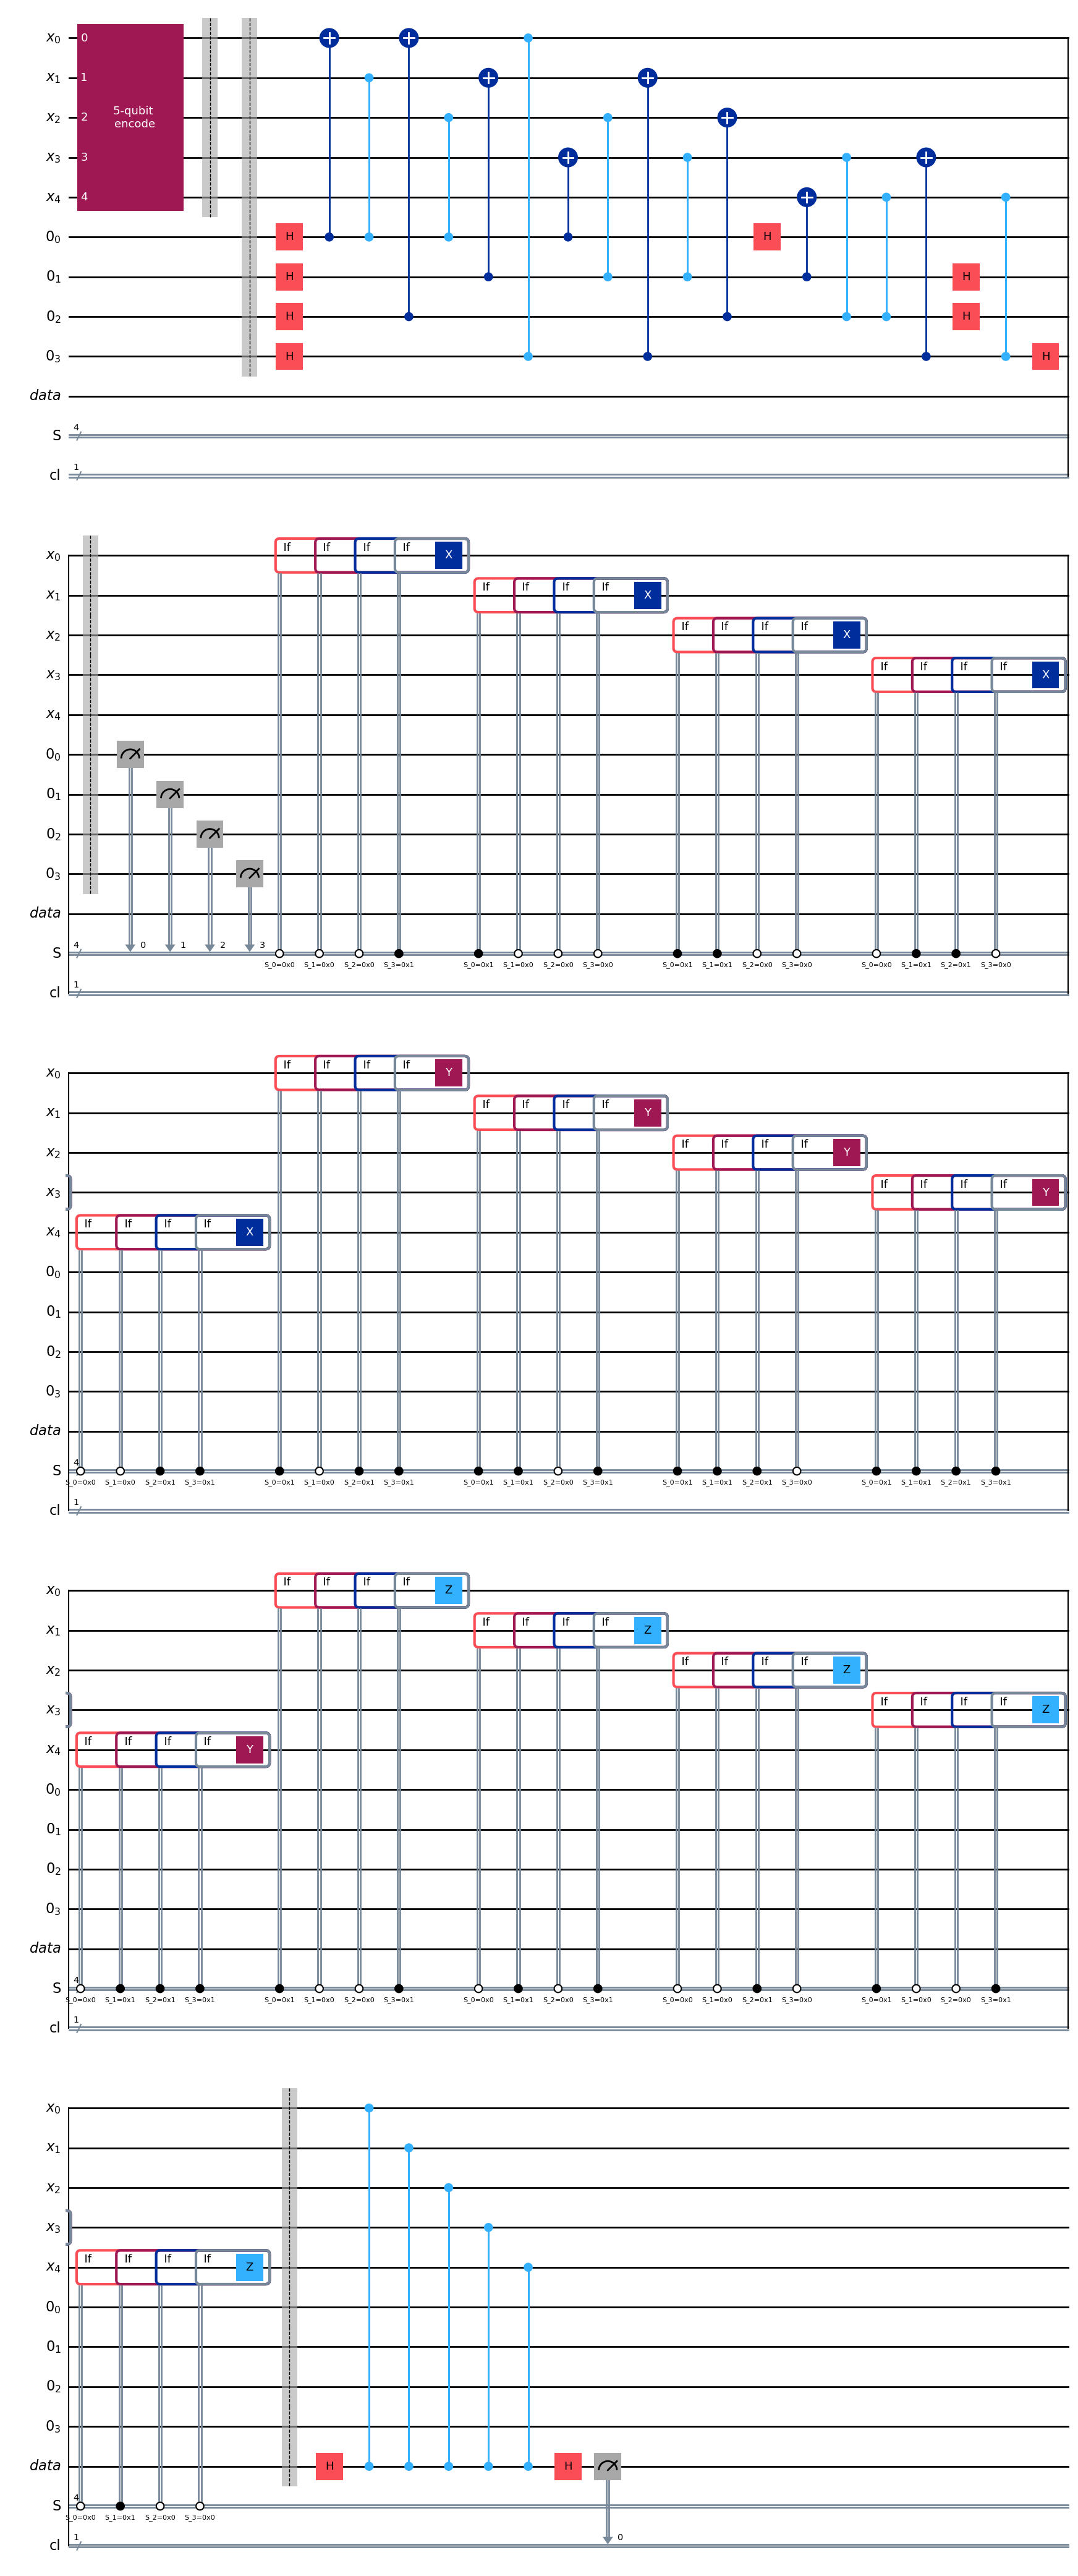

In [341]:
def MeasureData(qc, qr_physical):
    qr_data = QuantumRegister(1, name='data')
    qc.add_register(qr_data)
    qc.barrier()
    qc.h(qr_data)
    for i in range(5):
        qc.cz(qr_physical[i], qr_data)
    qc.h(qr_data)

    qr_cl = ClassicalRegister(1, name='cl')
    qc.add_register(qr_cl)
    qc.measure(qr_data, qr_cl)

MeasureData(qc, qr_physical)
qc.draw(output='mpl')

Now we put it all together and run a simulation to see if we did everything correctly

In [372]:
qr_physical = QuantumRegister(5, name='x')
qc= QuantumCircuit(qr_physical)

#Flip the below integer to encode 0 or 1
qc.compose(encodeGate(1),qr_physical, inplace=True)
qc.barrier()

syndrome = ClassicalRegister(4, name='S')
qc.add_register(syndrome)

#Applying a known error here for testing
qc.y(qr_physical[2]) 

apply_stabilizers(qc, qr_physical, syndrome)
CorrectErrors(qc, qr_physical, syndrome) 
MeasureData(qc, qr_physical)

#qc.draw(output='mpl')
simulator = AerSimulator()
# Transpile the circuit for the backend
compiled_circuit = transpile(qc, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=100)

# Get the measurement counts
counts = job.result().get_counts()
counts

#The first digit should be the same as the original input. The seond set should tell which syndromes were activated and match the lookup table (order should be reversed though).

#Something is wrong here. It seems to work correctly if the inout is 0, but messes up sometimes when the input is 1 (corrects the input to 0).

{'0 0010': 100}

{'0 1000': 500}

Testing below to see if the 0 and 1 state are prepared correctly as well as the measurement process working. It seems that they are.

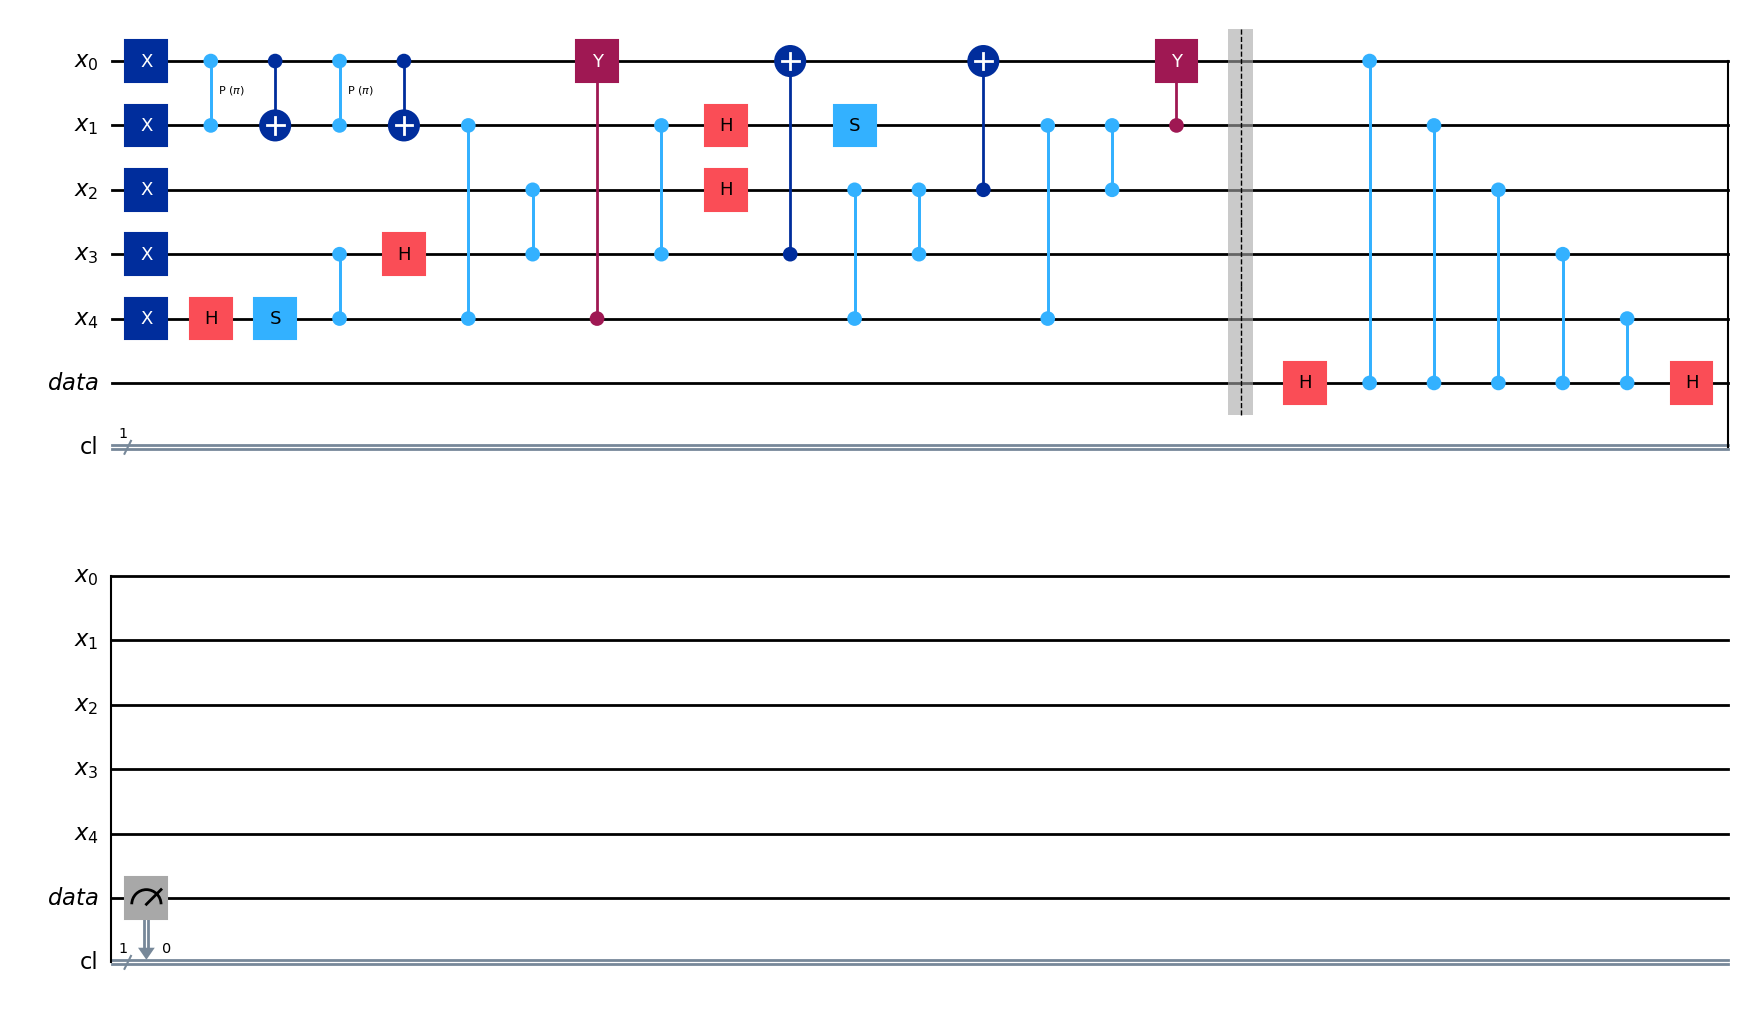

In [355]:
qr_physical = QuantumRegister(5, name='x')
qc= QuantumCircuit(qr_physical)
encode(1, qc, qr_physical)
MeasureData(qc, qr_physical)

qc.draw(output='mpl')

In [356]:
simulator = AerSimulator()
# Transpile the circuit for the backend
compiled_circuit = transpile(qc, simulator)

# Run the circuit
job = simulator.run(compiled_circuit, shots=100)

# Get the measurement counts
counts = job.result().get_counts()
counts

{'1': 100}